In [1]:
import os
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F  
from torchsummary import summary

from torch.utils.data import Dataset, DataLoader
from utils import load, get_audio_path, stereo_to_mono, add_noise, gain
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [2]:
DATA_DIR = './fma/data/fma_small'

tracks = load('fma/data/fma_metadata/tracks.csv')
#features = utils.load('fma/data/fma_metadata/features.csv')
#echonest = utils.load('fma/data/fma_metadata/echonest.csv')

subset = tracks.index[tracks['set', 'subset'] <= 'small']

#features_all = features.join(echonest, how='inner').sort_index(axis=1)

tracks = tracks.loc[subset]
#features_all = features.loc[subset]

train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

labels_onehot = LabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)

In [3]:
class FMADataset(Dataset):
    def __init__(self, data_dir, track_ids, augment_prob=0., precomputed=True, subsampling=True, sampling_rate=22050):
        self.data_dir = data_dir
        self.track_ids = track_ids
        self.sampling_rate = sampling_rate
        self.max_length = 750000
        self.subsampling = subsampling
        self.augment_prob = augment_prob
        self.precomputed = precomputed
        # create the Resample transform
        self.resample = torchaudio.transforms.Resample(44100, sampling_rate)
        
        
    def __getitem__(self, index):
        
        tid = self.track_ids[index]
        
    
        if not self.precomputed:
            # load the MP3 file
            filepath = utils.get_audio_path(self.data_dir, tid)
            try:
                waveform, sample_rate = torchaudio.load(filepath)
            except RuntimeError:
                return self.__getitem__(index + 1)

            waveform = stereo_to_mono(waveform) 

            # resample the waveform to the desired sample rate using the Resample transform
            waveform = self.resample(waveform)
        else:
            
            try:
                # load pre-computed waveform resampled to 22050
                filepath = os.path.join('./fma/data/waveforms/'+"{:06d}".format(tid)+'.pt')
                waveform = torch.load(filepath)
            except:
                return self.__getitem__(index + 1)
            
        if torch.rand(1) < self.augment_prob:
            waveform = add_noise(waveform)
            waveform = gain(waveform)
        
            
        
        # get label
        label = torch.from_numpy(labels_onehot.loc[tid].values).float()
        
        # subsampling
        if self.subsampling:
            # set the length of the subsamples and the overlap
            subsample_length = self.sampling_rate * 10  # 10 seconds
            overlap = int(subsample_length * 0.5)  # 50% overlap
            subsamples = []
            shift = subsample_length - overlap
            for i in range(0, waveform.size(0) - subsample_length + 1, shift):
                
                subsample = waveform[i:(i + subsample_length)]
     
                subsamples.append(subsample)
                if len(subsamples) == 4: break
                #if len(subsamples) == 7: break
            
            # ignore samples that have less than 30s (it should not be the case but there is a 15s sample in validation dataset we dont know why)
            if len(subsamples) != 4: return self.__getitem__(index + 1)
        
            # return the subsamples
            return subsamples, label
        else:
            # padding
            padding = self.max_length - waveform.shape[0]
            padding_tensor = torch.zeros((padding, waveform.shape[1]))
            waveform = torch.cat((waveform, padding_tensor), dim=0)

        
        return waveform, label

    def __len__(self):
        return int(len(self.track_ids)) # using ONLY 50% of the dataset for faster training

In [4]:
from networks_1D import ResNet1D

In [8]:
BATCH = 16
EPOCHS = 25
augment_prob = 0.8
p_dropout = 0.3


# create a training dataset and dataloader
dataset = FMADataset(DATA_DIR, train, precomputed=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH, shuffle=True)

# create a validation dataset and dataloader
val_dataset = FMADataset(DATA_DIR, val, precomputed=True, augment_prob=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH, shuffle=True)


    
for subsamples, label in dataloader:
    print(subsamples[0][0].size())
    break

model = ResNet1D(F=16, p_dropout=p_dropout, num_classes=8)
model.to(device)
saved_dict = torch.load("ResNet1D-S_B32_E35_OAdam_LR0.0001_pD0.3_A0.8_feb09_t2334_VAL0.5077_TRAIN0.4701.pt")
model.load_state_dict(saved_dict)


# define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()

# Adam optimizer
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters())
optimizer_name = 'Adam'


summary(model, (1, 110250))
timestamp = time.strftime("feb%d_t%H%M", time.gmtime())
model_name = f"{model.name}_B{BATCH}_E{EPOCHS}_O{optimizer_name}_LR{lr}_pD{p_dropout}_A{augment_prob}_{timestamp}"

torch.Size([110250])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 16, 36752]              48
            Conv1d-2            [-1, 16, 36752]             768
       BatchNorm1d-3            [-1, 16, 36752]              32
            Conv1d-4            [-1, 16, 36752]             768
       BatchNorm1d-5            [-1, 16, 36752]              32
            Conv1d-6            [-1, 16, 36752]             256
        Res1DLayer-7            [-1, 16, 36752]               0
         MaxPool1d-8             [-1, 16, 4083]               0
            Conv1d-9             [-1, 16, 4083]             768
      BatchNorm1d-10             [-1, 16, 4083]              32
           Conv1d-11             [-1, 16, 4083]             768
      BatchNorm1d-12             [-1, 16, 4083]              32
           Conv1d-13             [-1, 16, 4083]             256
       Res1DLayer-

In [6]:

# create the CNN model
#model = ResNet1D(input_size=110250, num_classes=8) # HERE YOU PUT UR NETWORK
#model.to(device)


# Lee 2017
# Define the optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

# Define the scheduler
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)



num_epochs = EPOCHS
running_loss = 0.0
best_val_loss = float('inf') # initialize the best validation loss


t2 = time.time()

# train the model
acc_tr = []
acc_val = []
loss_tr = []
loss_val = []

epoch_len = len(dataset) // BATCH


for epoch in range(num_epochs):
    i = 0
    
    # evaluate the model on the training dataset
    train_correct = 0
    train_total = 0
    
    for subsamples, label in dataloader:
        
        i += 1
        label = label.to(device)
        train_label = torch.argmax(label, dim=1)
        for waveform in subsamples:

            #t2 = time.time()
            # clear the gradients
            optimizer.zero_grad()
            waveform = waveform.to(device)
            # forward pass
            waveform = waveform.squeeze(0)  
            waveform = waveform.unsqueeze(1)
            
            output = model(waveform)
            loss = loss_fn(output, label)

            # backward pass
            loss.backward()
            optimizer.step()  
            
            # Update the learning rate
            # scheduler.step(loss)
            
            _, train_predicted = torch.max(output.data, 1)
            train_total += train_label.size(0)
            train_correct += (train_predicted == train_label).sum().item()

            running_loss += loss.item()
            #print(t2 - time.time())
 
    tr_loss = running_loss / len(dataloader)
    loss_tr.append(tr_loss)
    tr_acc = train_correct / train_total 
    acc_tr.append(tr_acc)
    t1 = (time.time() - t2) / 60 
    #print(epoch + 1, i, epoch_len, t1, loss,  tr_acc)
    running_loss = 0            
    model.eval()
    # evaluate the model on the validation dataset
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_subsamples, val_label in val_dataloader:
            val_label = val_label.to(device)
            val_label = torch.argmax(val_label, dim=1)
            for val_waveform in val_subsamples:
                val_waveform = val_waveform.squeeze(0)
                val_waveform = val_waveform.unsqueeze(1)
                val_waveform = val_waveform.to(device)
                val_output = model(val_waveform)
                val_loss += loss_fn(val_output, val_label).item()
                _, val_predicted = torch.max(val_output.data, 1)
                val_total += val_label.size(0)
                val_correct += (val_predicted == val_label).sum().item()


    loss = val_loss / len(val_dataloader)
    loss_val.append(loss)
    val_acc = val_correct / val_total
    acc_val.append(val_acc)
    # Save the model if the validation loss is the best seen so far
    if loss < best_val_loss:
        best_val_loss = loss
        best_val_acc = val_acc
        best_tr_acc = tr_acc
        best_state_dict = model.state_dict()
    print(f'[{epoch+1:d}, {i:d} / {epoch_len:d} batches - {t1:.2f} min]')
    print(f'Validation Accuracy: {val_acc:.4f} | Training Accuracy: {tr_acc:.4f}' + ' | Validation Loss: {:.4f} | Training loss: {:.4f} '.format(loss, tr_loss))  
    model.train()
                
plt.plot(loss_val, label='Validation loss')
plt.plot(loss_tr, label='Training loss')
plt.show()

plt.plot(acc_val, label='Validation accuracy')
plt.plot(acc_tr, label='Training accuracy')
plt.show()

torch.save(best_state_dict, model_name + f'_VAL{best_val_acc:.4f}_TRAIN{best_tr_acc:.4f}.pt')
print('Finished Training')

[1, 400 / 400 batches - 6.53 min]
Validation Accuracy: 0.2589 | Training Accuracy: 0.2216 | Validation Loss: 13.6578 | Training loss: 13.8836 
[2, 400 / 400 batches - 13.31 min]
Validation Accuracy: 0.2655 | Training Accuracy: 0.2452 | Validation Loss: 13.3280 | Training loss: 13.5089 
[3, 400 / 400 batches - 20.16 min]
Validation Accuracy: 0.3095 | Training Accuracy: 0.2533 | Validation Loss: 12.7897 | Training loss: 13.3625 
[4, 400 / 400 batches - 26.91 min]
Validation Accuracy: 0.3125 | Training Accuracy: 0.2692 | Validation Loss: 12.6176 | Training loss: 13.1940 
[5, 400 / 400 batches - 33.65 min]
Validation Accuracy: 0.2036 | Training Accuracy: 0.2736 | Validation Loss: 13.0091 | Training loss: 13.0750 
[6, 400 / 400 batches - 40.39 min]
Validation Accuracy: 0.3073 | Training Accuracy: 0.2910 | Validation Loss: 12.4545 | Training loss: 12.8655 
[7, 400 / 400 batches - 47.22 min]
Validation Accuracy: 0.3552 | Training Accuracy: 0.2983 | Validation Loss: 12.2162 | Training loss: 12

KeyboardInterrupt: 

In [7]:
# if keyboard interrupted:
#torch.save(best_state_dict, model_name + f'_VAL{best_val_acc:.4f}_TRAIN{best_tr_acc:.4f}.pt')
print(model_name + f'_VAL{best_val_acc:.4f}_TRAIN{best_tr_acc:.4f}.pt')
#model_name = "ResNet1D_2022-02-02_batchsize_8_epochs_30_opt_Adam_LR_0.0001_acc_0.4614"
#torch.save(model, model_name + '.pt')

ResNet1D-L_B16_E25_OAdam_LR0.0001_pD0.3_A0.8_feb10_t1033_VAL0.4150_TRAIN0.3838.pt


## Testing + aggregation + confusion matrix

In [ ]:
N_SUBSAMPLES = 7
# create a dataset object for testing
test_dataset = FMADataset(DATA_DIR, test, augment_prob=0, sampling_rate=22050)
batch_size = 2
# create a data loader to load the dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# model = ResNet1D(F=32)
# model_name = 'ResNet1D-M_B32_E10_OAdam_LR0.0001_pD0.3_A0.8_feb10_t0944_VAL0.4986_TRAIN0.4848'
# saved_dict = torch.load(f'{model_name}.pt')
# model.load_state_dict(saved_dict)
from networks_1D import SoundNet1D
model_name = "SoundNet_2022-01-25_batchsize_32_epochs_10_20_opt_Adam_LR_0.0001_acc_0.4519.pt"
model = torch.load(model_name)
# test the model
model.eval()
model.to(device)
correct = 0
correct_agg = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad(): # don't need to track, calculate or save the gradients in the model
    for subsamples, labels in test_loader:
        labels = labels.to(device)
        labels = torch.argmax(labels, dim=1).cpu()
        batch_size = labels.size(0) # we reupdate the batch size because the last batch can be incomplete.
        subsample_outputs = {i: [] for i in range(batch_size)}
        for waveform in subsamples:
            waveform = waveform.squeeze(0)  
            waveform = waveform.unsqueeze(1)
            waveform = waveform.to(device)
            outputs = model(waveform)
            predicted = torch.argmax(outputs.data, dim=1).cpu()
            
            for j in range(batch_size):
                subsample_outputs[j].append(predicted[j]) 
        for j in range(batch_size):
            # count the occurrences of each class
            counts = np.bincount(subsample_outputs[j])
            # Find the class with the highest count
            aggregate_prediction = np.argmax(counts)
            correct += np.sum([subsample_outputs[j][i] == labels[j] for i in range(N_SUBSAMPLES)])
            correct_agg += (aggregate_prediction == labels[j])
            all_preds.append(aggregate_prediction)
            all_labels.append(labels[j])
        total += labels.size(0)
        

print('Test accuracy without aggregation: %f %%' % (100/7 * correct / total))
print('Test accuracy with aggregation: %f %%' % (100 * correct_agg / total))

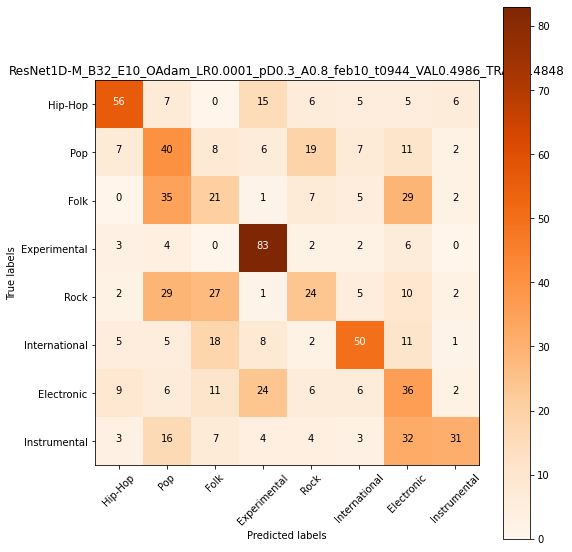

In [17]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):

     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
    
from sklearn.metrics import confusion_matrix    
import itertools
# a tuple for all the class names
genre = tracks.track.genre_top.unique().to_list()
cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, genre, title=model_name)


# 